<a href="https://colab.research.google.com/github/yvsim001/projekt/blob/main/MNIST_mit_MobilNetV1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.23.5
!pip install scipy==1.10.1
!pip install pandas==2.0.0
!pip install tensorflow==2.16.2
!pip install scikit-learn==1.2.2

  Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.15 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jax 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
mizani 0.11.4 requires pandas>=2.1.0, but you have pandas 2.0.0 which is incompatible.
plotnine 0.13.6 requires pandas<3.0.0,>=2.1.0, but you have pandas 2.0.0 which is incompatible.
scikit-image 0.24.0 requires p

In [2]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow import keras
import keras
from keras import layers

print(tf.__version__)
print(keras.__version__)

2.16.2
3.4.1


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Model / data parameters
H, W, C = 28, 28, 1
IN_SHAPE = (H, W, C)
NB_CLASSES = 10

# Load the data and split it between train and test sets
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()



x_train = x_train.reshape(x_train.shape[0], H, W, C)
x_test = x_test.reshape(x_test.shape[0], H, W, C)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NB_CLASSES)
y_test = keras.utils.to_categorical(y_test, NB_CLASSES)

x_train.dtype

dtype('float32')

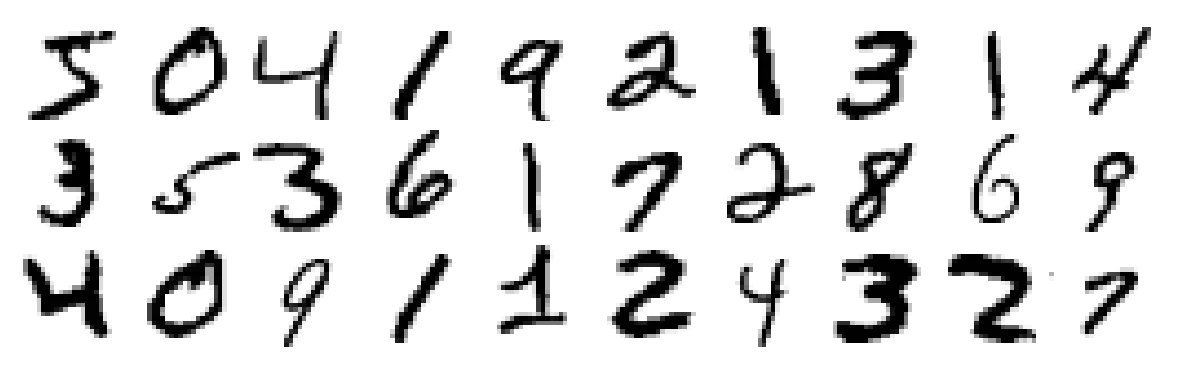

In [7]:
import matplotlib.pyplot as plt
# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [8]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.10,
        width_shift_range=0.1,
        height_shift_range=0.1
        )

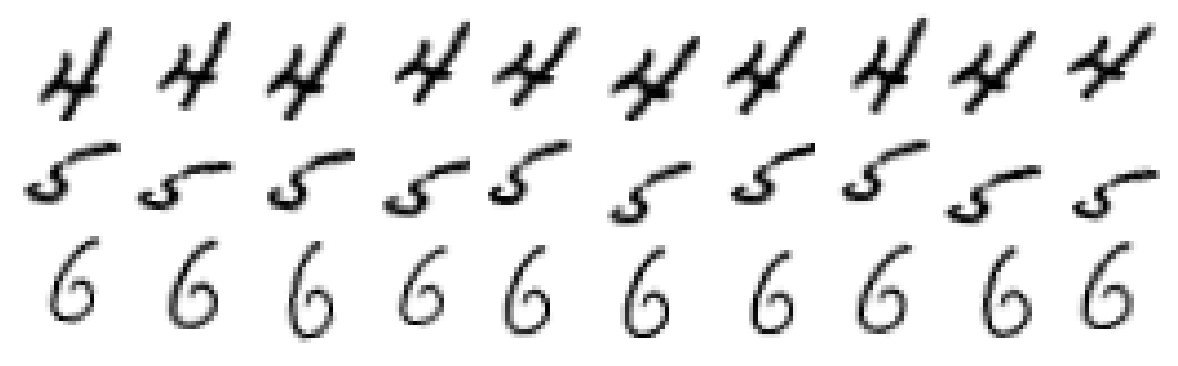

In [9]:
# PREVIEW AUGMENTED IMAGES
X_train3 = x_train[9].reshape((1, 28, 28, 1))
Y_train3 = y_train[9].reshape((1, 10))
plt.figure(figsize=(15, 4.5))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    X_train2, Y_train2 = next(datagen.flow(X_train3, Y_train3))
    plt.imshow(X_train2[0].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis('off')
    if i == 9: X_train3 = x_train[11].reshape((1, 28, 28, 1))
    if i == 19: X_train3 = x_train[18].reshape((1, 28, 28, 1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [12]:
import numpy as np

import tensorflow as tf


from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

def mobilenet_v1():
    # Mobilenet parameters
    input_shape = [28,28,1]
    num_classes = 10
    num_filters = 8 # normally 32, but running with alpha=.25 per EEMBC requirement

    inputs = Input(shape=input_shape)
    x = inputs # Keras model uses ZeroPadding2D()

    # 1st layer, pure conv
    # Keras 2.2 model has padding='valid' and disables bias
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) # Keras uses ReLU6 instead of pure ReLU

    # 2nd layer, depthwise separable conv
    # Filter size is always doubled before the pointwise conv
    # Keras uses ZeroPadding2D() and padding='valid'
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3rd layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 4th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 5th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 6th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 7th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 8th-12th layers, identical depthwise separable convs
    # 8th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 9th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 10th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 11th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 12th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 13th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 14th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D
    x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
model = mobilenet_v1()

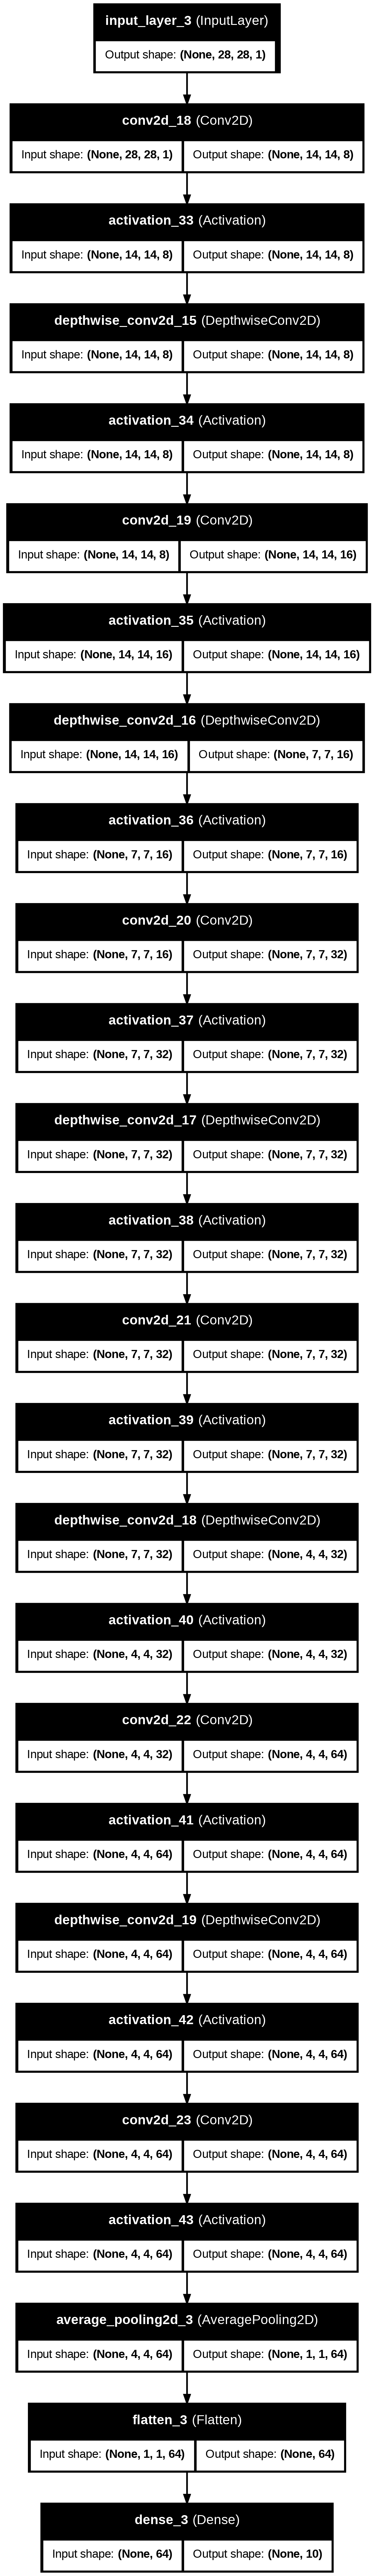

In [49]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
import numpy as np

import tensorflow as tf


from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
IMAGE_SIZE = 28
BATCH_SIZE = 32
EPOCHS = 20

import tensorflow as tf

from tensorflow.keras import layers, models

def meinMNIST():
  # Mobilenet parameters
    input_shape = [28,28,1] # resized to 28*28
    num_classes = 10
    num_filters = 8 # normally 32, but running with alpha=.25 per EEMBC requirement
    inputs = Input(shape=input_shape)
    x = inputs # Keras model uses ZeroPadding2D()

    # 1st layer, pure conv
    # Keras 2.2 model has padding='valid' and disables bias
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(0.0001))(x)
    x = Activation('relu')(x) # Keras uses ReLU6 instead of pure ReLU

    # 2nd layer, depthwise separable conv
    # Filter size is always doubled before the pointwise conv
    # Keras uses ZeroPadding2D() and padding='valid'
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = Activation('relu')(x)

    # 3rd layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = Activation('relu')(x)

    # 4th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = Activation('relu')(x)

    # 5th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = Activation('relu')(x)


    # 6th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  depthwise_initializer='he_normal',
                  depthwise_regularizer=l2(1e-4))(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = Activation('relu')(x)

    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D
    x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = meinMNIST()




from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)






In [13]:
batch_size = 32
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 115s 50ms/step - accuracy: 0.3507 - loss: 2.1428 - val_accuracy: 0.8873 - val_loss: 0.6436
Epoch 2/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 140s 49ms/step - accuracy: 0.8758 - loss: 0.6800 - val_accuracy: 0.9465 - val_loss: 0.4313
Epoch 3/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 139s 47ms/step - accuracy: 0.9367 - loss: 0.4558 - val_accuracy: 0.9608 - val_loss: 0.3493
Epoch 4/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 81s 47ms/step - accuracy: 0.9541 - loss: 0.3703 - val_accuracy: 0.9748 - val_loss: 0.2793
Epoch 5/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 87s 50ms/step - accuracy: 0.9653 - loss: 0.3050 - val_accuracy: 0.9778 - val_loss: 0.2489
Epoch 6/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 146s 52ms/step - accuracy: 0.9700 - loss: 0.2633 - val_accuracy: 0.9787 - val_loss: 0.2180
Epoch 7/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 137s 49ms/step - accuracy: 0.9733 - loss: 0.2326 - val_accuracy: 0.9785 - val_loss: 0.1993
Epoch 8/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 140s 48ms/step - accuracy: 0.

In [14]:
 # Print training and validation accuracy
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(
    epochs, max(history.history['accuracy']), max(history.history['val_accuracy'])
))

CNN: Epochs=15, Train accuracy=0.98489, Validation accuracy=0.98867


In [15]:
model.summary()
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 14, 14, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_13                  │ (None, 14, 14, 8)           │              80 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 14, 14, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 16)          │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 14, 14, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_14                  │ (None, 7, 7, 16)            │             160 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 7, 7, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 7, 7, 32)            │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_15                  │ (None, 7, 7, 32)            │             320 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 660,176 (2.52 MB)

 Trainable params: 218,234 (852.48 KB)

 Non-trainable params: 5,472 (21.38 KB)

 Optimizer params: 436,470 (1.67 MB)

Test loss: 0.13164229691028595
Test accuracy: 0.9842000007629395


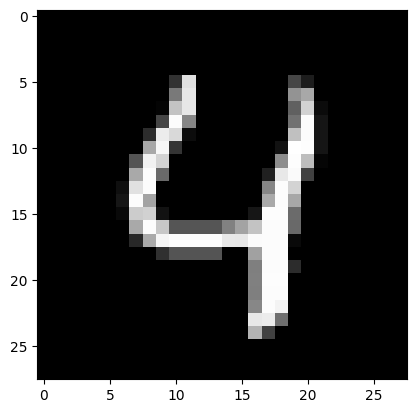

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions (in percentages) for each class:
Class 0: 0.00%
Class 1: 0.02%
Class 2: 0.00%
Class 3: 0.00%
Class 4: 99.91%
Class 5: 0.00%
Class 6: 0.00%
Class 7: 0.01%
Class 8: 0.01%
Class 9: 0.05%


In [16]:
import matplotlib.pyplot as plt
test_images = x_test
# For example, if test_images[4] is a single image with shape (28, 28, 1)
img = test_images[4]

# Display the image
plt.imshow(img.squeeze(), cmap='gray')
plt.show()

# Reshape the image to match the model's input requirements (1, 28, 28, 1)
img_reshaped = np.expand_dims(img, axis=0)

# Predict using the reshaped image
prediction = model.predict(img_reshaped)

# Print the prediction
print("Predictions (in percentages) for each class:")
for idx, prob in enumerate(prediction[0]):
    print(f"Class {idx}: {prob*100:.2f}%")

In [17]:
model.save('/content/drive/MyDrive/trained_models/meinMNIST_V1.h5')
model.export('/content/drive/MyDrive/trained_models/meinMNIST_V1')

Saved artifact at '/content/drive/MyDrive/trained_models/meinMNIST_V1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_85')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137821279765072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137821279764544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137821279768592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137821279780560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137821279776688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137821279777568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137821279779328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137821279768768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137821279773168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137821277064176: TensorSpec(shape=(), dtype=tf.r

In [18]:
# test the model
_, acc = model.evaluate(x_test, y_test, verbose=0)

print("acc = {:.2f}".format(acc))

acc = 0.98


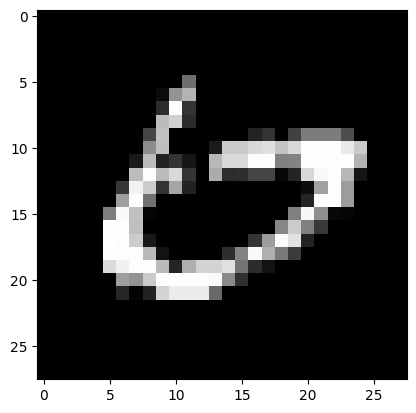

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
Predictions (in percentages) for each class:
Class 0: 0.00%
Class 1: 0.00%
Class 2: 0.00%
Class 3: 100.00%
Class 4: 0.00%
Class 5: 0.00%
Class 6: 0.00%
Class 7: 0.00%
Class 8: 0.00%
Class 9: 0.00%


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image from the specified path and resize it to 28x28
# Convert the image to an array
img_array = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,147,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,253,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,188,209,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,69,192,0,0,0,0,0,0,35,51,0,65,124,124,124,77,0,0,0,0,0,0,0,0,0,0,0,0,140,190,0,0,0,26,202,202,216,223,196,216,253,253,253,233,202,0,0,0,0,0,0,0,0,0,0,26,187,34,52,22,0,184,216,217,253,253,128,131,253,253,253,253,179,0,0,0,0,0,0,0,0,0,0,189,253,187,217,52,0,172,45,46,69,69,7,36,215,248,253,182,21,0,0,0,0,0,0,0,0,0,55,242,204,51,165,34,0,0,0,0,0,0,0,0,13,162,253,156,0,0,0,0,0,0,0,0,0,0,158,253,113,0,0,0,0,0,0,0,0,0,0,0,36,253,253,156,0,0,0,0,0,0,0,0,0,126,250,193,4,0,0,0,0,0,0,0,0,0,0,128,247,142,8,5,0,0,0,0,0,0,0,0,0,254,253,191,0,0,0,0,0,0,0,0,0,0,134,203,128,57,0,0,0,0,0,0,0,0,0,0,0,255,253,204,24,0,0,0,0,0,0,0,52,156,250,225,34,0,0,0,0,0,0,0,0,0,0,0,0,254,253,253,185,18,0,0,0,0,46,131,249,175,122,59,0,0,0,0,0,0,0,0,0,0,0,0,0,219,240,253,253,186,36,175,211,211,225,115,43,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,158,146,202,253,253,253,253,249,138,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,4,34,212,235,235,235,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
img_array = np.array(img_array)

# Reshaping the array into 28x28x1
img_array= np.array(img_array).reshape(28, 28, 1)
# Display the resized image

plt.imshow(img_array.squeeze(), cmap='gray')
plt.show()

# Reshape the image to match the model's input requirements (1, 28, 28, 1)
img_reshaped = np.expand_dims(img_array, axis=0)

# Predict using the reshaped image
prediction = model.predict(img_reshaped)

# Print the prediction
print("Predictions (in percentages) for each class:")
for idx, prob in enumerate(prediction[0]):
    print(f"Class {idx}: {prob*100:.2f}%")

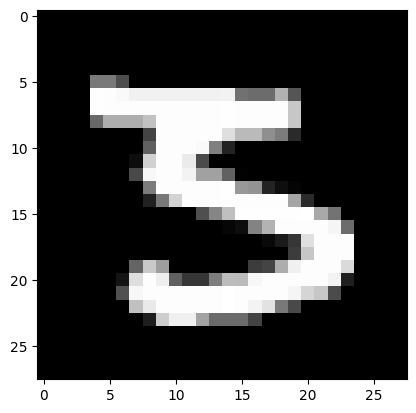

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predictions (in percentages) for each class:
Class 0: 0.00%
Class 1: 0.00%
Class 2: 0.00%
Class 3: 100.00%
Class 4: 0.00%
Class 5: 0.00%
Class 6: 0.00%
Class 7: 0.00%
Class 8: 0.00%
Class 9: 0.00%


In [20]:

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image from the specified path and resize it to 28x28
# Convert the image to an array
img_array = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,122,121,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,254,253,249,241,241,241,241,241,241,241,242,114,108,108,178,85,0,0,0,0,0,0,0,0,0,0,0,0,254,253,253,253,253,253,253,253,253,253,254,253,253,253,253,199,0,0,0,0,0,0,0,0,0,0,0,0,104,173,173,173,194,253,253,253,253,253,254,253,253,253,253,199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,253,253,253,253,253,223,186,186,143,124,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,96,253,253,253,250,128,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,209,253,253,235,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,248,253,253,243,161,161,98,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,124,253,253,253,253,253,254,152,147,35,14,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,120,211,253,253,253,254,253,253,253,253,165,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79,134,192,254,254,254,254,254,255,169,115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,13,132,180,253,253,253,253,245,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,26,54,224,253,253,253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,199,253,253,253,0,0,0,0,0,0,0,0,0,0,0,100,201,158,0,0,0,0,0,0,61,68,173,240,253,253,253,218,0,0,0,0,0,0,0,0,0,0,20,222,253,239,96,54,54,125,188,187,247,253,253,253,253,253,243,31,0,0,0,0,0,0,0,0,0,0,80,247,253,253,253,253,253,253,255,253,253,253,253,245,213,199,75,0,0,0,0,0,0,0,0,0,0,0,0,192,233,253,253,253,253,253,255,253,243,226,121,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,205,240,240,162,107,107,107,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
img_array = np.array(img_array)

# Reshaping the array into 28x28x1
img_array= np.array(img_array).reshape(28, 28, 1)
# Display the resized image

plt.imshow(img_array.squeeze(), cmap='gray')
plt.show()

# Reshape the image to match the model's input requirements (1, 28, 28, 1)
img_reshaped = np.expand_dims(img_array, axis=0)

# Predict using the reshaped image
prediction = model.predict(img_reshaped)

# Print the prediction
print("Predictions (in percentages) for each class:")
for idx, prob in enumerate(prediction[0]):
    print(f"Class {idx}: {prob*100:.2f}%")

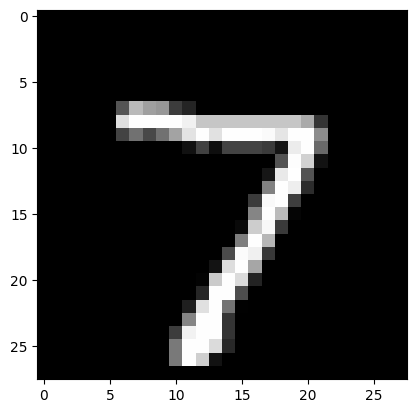

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predictions (in percentages) for each class:
Class 0: 0.00%
Class 1: 0.00%
Class 2: 0.00%
Class 3: 100.00%
Class 4: 0.00%
Class 5: 0.00%
Class 6: 0.00%
Class 7: 0.00%
Class 8: 0.00%
Class 9: 0.00%


In [56]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image from the specified path and resize it to 28x28
# Convert the image to an array
img_array = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,185,159,151,60,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222,254,254,254,254,241,198,198,198,198,198,198,198,198,170,52,0,0,0,0,0,0,0,0,0,0,0,0,67,114,72,114,163,227,254,225,254,254,254,250,229,254,254,140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,66,14,67,67,67,59,21,236,254,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,253,209,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,233,255,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,254,238,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,249,254,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,254,187,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,205,248,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126,254,182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,251,240,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,221,254,166,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,203,254,219,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,254,254,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,224,254,115,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,254,254,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,242,254,254,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,254,219,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,207,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
img_array = np.array(img_array)

# Reshaping the array into 28x28x1
img_array= np.array(img_array).reshape(28, 28, 1)
# Display the resized image

plt.imshow(img_array.squeeze(), cmap='gray')
plt.show()

# Reshape the image to match the model's input requirements (1, 28, 28, 1)
img_reshaped = np.expand_dims(img_array, axis=0)

# Predict using the reshaped image
prediction = model.predict(img_reshaped)

# Print the prediction
print("Predictions (in percentages) for each class:")
for idx, prob in enumerate(prediction[0]):
    print(f"Class {idx}: {prob*100:.2f}%")

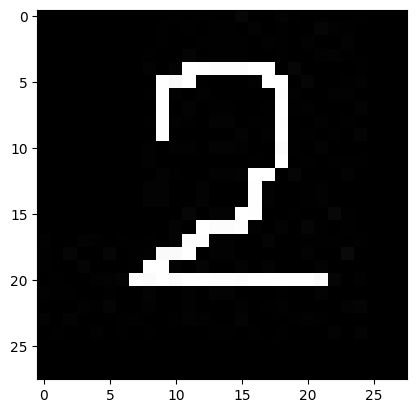

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predictions (in percentages) for each class:
Class 0: 0.00%
Class 1: 0.00%
Class 2: 0.00%
Class 3: 100.00%
Class 4: 0.00%
Class 5: 0.00%
Class 6: 0.00%
Class 7: 0.00%
Class 8: 0.00%
Class 9: 0.00%


In [52]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image from the specified path and resize it to 28x28
img_path = "/content/drive/MyDrive/RANDOM_IMAGE_FOR_TEST/Nummer_2.jpg"
img = load_img(img_path, color_mode='grayscale', target_size=(28, 28))

# Convert the image to an array
img_array = 255 - img_to_array(img) -128#invert the color


# Display the resized image
plt.imshow(img_array.squeeze(), cmap='gray')
plt.show()

# Reshape the image to match the model's input requirements (1, 28, 28, 1)
img_reshaped = np.expand_dims(img_array, axis=0)

# Predict using the reshaped image
prediction = model.predict(img_reshaped)

# Print the prediction
print("Predictions (in percentages) for each class:")
for idx, prob in enumerate(prediction[0]):
    print(f"Class {idx}: {prob*100:.2f}%")

In [23]:
import tensorflow as tf
import numpy as np

saved_model_dir ="/content/drive/MyDrive/trained_models/meinMNIST_V1"

TF_LITE_MODEL_FILE_NAME="/content/drive/MyDrive/trained_models/meinMNIST_V1.tflite"
# Define the representative dataset generation function
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(np.random.rand(100, 28, 28,1).astype(np.float32)).batch(1).take(100):
        yield [input_value]

# Convert the saved model to a TFLite model with full integer quantization
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # Ensure the input type is int8 for quantization
converter.inference_output_type = tf.int8  # Ensure the output type is int8 for quantization
tflite_model = converter.convert()


# Save the model.
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

310136

In [40]:
# Load the quantized TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/trained_models/meinMNIST_V1.tflite")


input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


# Adjust the model interpreter to take 10,000 inputs at once instead of just 1
interpreter.resize_tensor_input(input_details[0]["index"], (10000, 28,28,1))
interpreter.resize_tensor_input(output_details[0]["index"], (10000, 10))

interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()



# Set the test input and run
interpreter.set_tensor(input_details[0]["index"], (x_test*255+128).astype('int8')) # Cast x_test to float32
interpreter.invoke()

# Get the result and check its accuracy
output_data = (interpreter.get_tensor(output_details[0]["index"]))
y_test = y_test.astype(np.uint8)

predicted_classes = [np.argmax(y, axis=None, out=None) for y in output_data]
true_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

accuracy = (np.array(predicted_classes) == np.array(true_classes)).mean()
print("TFLite Accuracy:", accuracy)

TFLite Accuracy: 0.9844


In [41]:
def print_zeropoints_und_scaled(interpreter):
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  print("Input scale, zero_point = {}, {}".format(input_details[0]['quantization'][0], input_details[0]['quantization'][1]))
  print("Output scale, zero_point = {}, {}".format(output_details[0]['quantization'][0], output_details[0]['quantization'][1]))

def print_all_tensor_details(interpreter):
  tensor_details = interpreter.get_tensor_details()
  for tensor in tensor_details:
    print(tensor)

In [42]:
print_zeropoints_und_scaled(interpreter)

Input scale, zero_point = 0.0039215655997395515, -128
Output scale, zero_point = 0.00390625, -128


In [43]:
print_all_tensor_details(interpreter)

{'name': 'serving_default_keras_tensor_85:0', 'index': 0, 'shape': array([10000,    28,    28,     1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0039215655997395515, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'arith.constant', 'index': 1, 'shape': array([2], dtype=int32), 'shape_signature': array([2], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'tfl.pseudo_qconst', 'index': 2, 'shape': array([10], dtype=int32), 'shape_signature': array([10], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (4.9423037125961855e-05, 0), 'quantization_parameters': {'scales': array([4

In [44]:
!pip install tvm --pre

In [45]:
!pip install apache-tvm --pre

In [46]:
!pip install pyserial==3.5 tflite==2.1 Pillow==9.0 typing_extensions

In [47]:
import json
import tarfile
import pathlib
import tempfile
import numpy as np

import tvm
import tvm.micro
import tvm.micro.testing
from tvm import relay
import tvm.contrib.utils
from tvm.micro import export_model_library_format
from tvm.contrib.download import download_testdata

In [48]:
MODEL_URL = "/content/drive/MyDrive/trained_models/meinMNIST_V1.tflite"
MODEL_NAME = "meinMNIST_V1.tflite"

tflite_model_buf = open(MODEL_URL, "rb").read()
try:
    import tflite

    tflite_model = tflite.Model.GetRootAsModel(tflite_model_buf, 0)
except AttributeError:
    import tflite.Model

    tflite_model = tflite.Model.Model.GetRootAsModel(tflite_model_buf, 0)



input_tensor = 'serving_default_input_layer_9:0'  # Use the name from input_details
input_shape = (1, 28, 28,1)  # This should be a tuple
input_dtype = 'float32'          # This should be a string


# Parse TFLite model and convert it to a Relay module
from tvm import relay, transform

mod, params = relay.frontend.from_tflite(
    tflite_model, shape_dict={input_tensor: input_shape}, dtype_dict={input_tensor: input_dtype}
)

# Print the Relay module to inspect the weights
print(mod)

# Check the type and shape of the weight tensors
for name, param in params.items():
    print(f"Name: {name}, Type: {type(param)}, Shape: {param.shape}")

def @main(%serving_default_keras_tensor_85:0: Tensor[(1, 28, 28, 1), int8] /* span=serving_default_keras_tensor_85:0:0:0 */, %v_param_1: Tensor[(3, 3, 1, 8), int8] /* span=tfl.pseudo_qconst55:0:0 */, %v_param_2: Tensor[(8), int32] /* span=tfl.pseudo_qconst54:0:0 */, %v_param_3: Tensor[(3, 3, 8, 1), int8] /* span=tfl.pseudo_qconst53:0:0 */, %v_param_4: Tensor[(8), int32] /* span=tfl.pseudo_qconst52:0:0 */, %v_param_5: Tensor[(1, 1, 8, 16), int8] /* span=tfl.pseudo_qconst51:0:0 */, %v_param_6: Tensor[(16), int32] /* span=tfl.pseudo_qconst50:0:0 */, %v_param_7: Tensor[(3, 3, 16, 1), int8] /* span=tfl.pseudo_qconst49:0:0 */, %v_param_8: Tensor[(16), int32] /* span=tfl.pseudo_qconst48:0:0 */, %v_param_9: Tensor[(1, 1, 16, 32), int8] /* span=tfl.pseudo_qconst47:0:0 */, %v_param_10: Tensor[(32), int32] /* span=tfl.pseudo_qconst46:0:0 */, %v_param_11: Tensor[(3, 3, 32, 1), int8] /* span=tfl.pseudo_qconst45:0:0 */, %v_param_12: Tensor[(32), int32] /* span=tfl.pseudo_qconst44:0:0 */, %v_param_13

In [50]:
import os
import numpy as np
import pathlib
import json
from PIL import Image
import tarfile

import tvm
from tvm import relay
from tvm.relay.backend import Executor, Runtime
from tvm.contrib.download import download_testdata
from tvm.micro import export_model_library_format
from tvm.relay.op.contrib import cmsisnn
from tvm.micro.testing.utils import create_header_file

In [51]:
# We can use TVM native schedules or rely on the CMSIS-NN kernels using TVM Bring-Your-Own-Code (BYOC) capability.
USE_CMSIS_NN = True

# USMP (Unified Static Memory Planning) performs memory planning of all tensors holistically to achieve best memory utilization
DISABLE_USMP = False

# Use the C runtime (crt)
RUNTIME = Runtime("crt")

# We define the target by passing the board name to `tvm.target.target.micro`.
# If your board is not included in the supported models, you can define the target such as:
#TARGET = tvm.target.Target("c -keys=arm_cpu,cpu -mcpu=cortex-m4")
TARGET = tvm.target.target.micro("stm32l4r5zi")

# Use the AOT executor rather than graph or vm executors. Use unpacked API and C calling style.
EXECUTOR = tvm.relay.backend.Executor(
    "aot", {"unpacked-api": True, "interface-api": "c", "workspace-byte-alignment": 8}
)

# Now, we set the compilation configurations and compile the model for the target:
config = {"tir.disable_vectorize": True}
#if USE_CMSIS_NN:
#    config["relay.ext.cmsisnn.options"] = {"mcpu": TARGET.mcpu}
#if DISABLE_USMP:
#    config["tir.usmp.enable"] = False

with tvm.transform.PassContext(opt_level=3, config=config):
    if USE_CMSIS_NN:
        # When we are using CMSIS-NN, TVM searches for patterns in the
        # relay graph that it can offload to the CMSIS-NN kernels.
        mod = cmsisnn.partition_for_cmsisnn(mod, params, mcpu=TARGET.mcpu)
        lowered = tvm.relay.build(
        mod, target=TARGET, params=params, runtime=RUNTIME, executor=EXECUTOR
    )
parameter_size = len(tvm.runtime.save_param_dict(lowered.get_params()))
print(f"Model parameter size: {parameter_size}")

# We need to pick a directory where our file will be saved.
# If running on Google Colab, we'll save everything in ``/root/tutorial`` (aka ``~/tutorial``)
# but you'll probably want to store it elsewhere if running locally.

BUILD_DIR = pathlib.Path("/content/drive/MyDrive/Rar_files")

BUILD_DIR.mkdir(exist_ok=True)

# Now, we export the model into a tar file:
TAR_PATH = pathlib.Path(BUILD_DIR) / "model_meinMNIST2.tar"
export_model_library_format(lowered, TAR_PATH)

Model parameter size: 32


PosixPath('/content/drive/MyDrive/Rar_files/model_meinMNIST2.tar')